# Ernesto Antonio Reyes Ramírez

# Procesamiento de Lenguaje Natural

# Tarea 3

Primero procesamos todo el conjunto de datos que utilizaremos

In [14]:
import os
import re
from keras.preprocessing.text import Tokenizer
import numpy as np
import math

In [3]:
def get_texts_from_file(path_corpus,path_truth):
    tr_text = []
    tr_y = []
    
    with open(path_corpus,"r") as f_corpus, open(path_truth,"r") as f_truth:
        for twitt in f_corpus:
            tr_text += [twitt]
        for label in f_truth:
            tr_y += [label]
    return tr_text,tr_y

In [4]:
tr_text,tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

In [5]:
import nltk 
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [6]:
corpus_palabras = []

for doc in tr_text:
    corpus_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_palabras)

In [8]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key],key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [9]:
V = sortFreqDict(fdist)
V = V[:5000]

In [10]:
dict_indices = dict()
cont = 0 

for weight, word in V:
    dict_indices[word] = cont
    cont += 1

# BoW

In [13]:
def build_bow_tr(tr_text,V,dict_indices):
    BOW = np.zeros((len(tr_text),len(V)),dtype=int)
    cont_doc = 0
    for tr in tr_text:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc,dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
    
    return BOW

In [12]:
BOW_tr = build_bow_tr(tr_text,V,dict_indices)

# 1. Calcular TCOR 

In [23]:
#Vamos a construir una matriz termino a termino donde cada entrada guarda la cantidad de documentos
# en los que co-ocurren

def build_ccmatrix(bow):
    t_v = bow.shape[1]
    cc = np.zeros((t_v, t_v), dtype = int)
    for idoc in range(bow.shape[0]):
        iw = np.nonzero(bow[idoc])[0] 
        for i in range(len(iw)):
            for j in range(i,len(iw)):
                cc[iw[i], iw[j]] += 1
                cc[iw[j], iw[i]] += 1  
    return cc

cc_tr = build_ccmatrix(BOW_tr)

In [25]:
#Funcion que calcula TCOR
def compute_tcor(TR):
    
    TR_subset_in = TR
    
    DTR = np.zeros((TR_subset_in.shape[1],TR_subset_in.shape[1]),dtype=float)
    
    tam_V = TR_subset_in.shape[1]
    
    for i in range(tam_V):
        nonzero = np.nonzero(TR_subset_in)[0]    
        for j in range(tam_V):
            if (i==j):
                DTR[i,j] = 0
            else:
                if(TR_subset_in[i,j] == 0):
                    DTR[i,j] = 0
                else:
                    DTR[i,j] = (1 + math.log10(TR_subset_in[i,j])) * math.log10(tam_V/len(nonzero)) 
    return DTR

In [26]:
from sklearn import preprocessing 
tcor_tr  = compute_tcor(cc_tr)
tcor_tr = preprocessing.normalize(tcor_tr, norm ="l2") # tcor normalizado

In [27]:
from sklearn.feature_selection import SelectKBest, chi2

# Selecciona los 1000 términos mas relevantes tomando la información de la BoW
feats = SelectKBest(chi2, k = 1000)
feats.fit(BOW_tr, tr_y)
best = feats.get_support(indices = True) # Indices (en la BoW) de términos seleccionados

# Diccionario (ranking -> palabra) 
dict_indice_invertido = {} 
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w
    
# términos mas relevantes    
relevantw = [ dict_indice_invertido[index] for index in best] # termnos mas relevantes

In [28]:
# Se toma TCOR con las 1000 palabras mas relevantes
tcor_relevantw  = np.array([tcor_tr[dict_indices[word]] for word in relevantw])

# Se realiza reducción de dimensionalidad con tsne
from tsne import tsne
tcor_reduced = tsne(tcor_relevantw, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.159189
Iteration 10: error is 17.675766
Iteration 20: error is 17.432951
Iteration 30: error is 17.324363
Iteration 40: error is 17.347447
Iteration 50: error is 17.272526
Iteration 60: error is 17.289814
Iteration 70: error is 17.283520
Iteration 80: error is 17.282404
Iteration 90: error is 17.276660
Iteration 100: error is 17.278088
Iteration 110: error is 2.198771
Iteration 120: error is 1.821413
Iteration 130: error is 1.684717
Iteration 140: error is 1.606701
Iteration 150: error is 1.555059
Iteration 160: error is 1.520094
Iteration 170: error is 1.494337
Iteration 180: error is 1.474208
Iteration 190: error is 1.458231
Iteration 200: error is 1.445237
Iteration 210: error is 1.434263
Iteration 220: error is 1.425029
Iteration 230: error is 1.417316
Iteration 240: error is 1.410967
Iteration 250: error is

/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  fig.canvas.pr

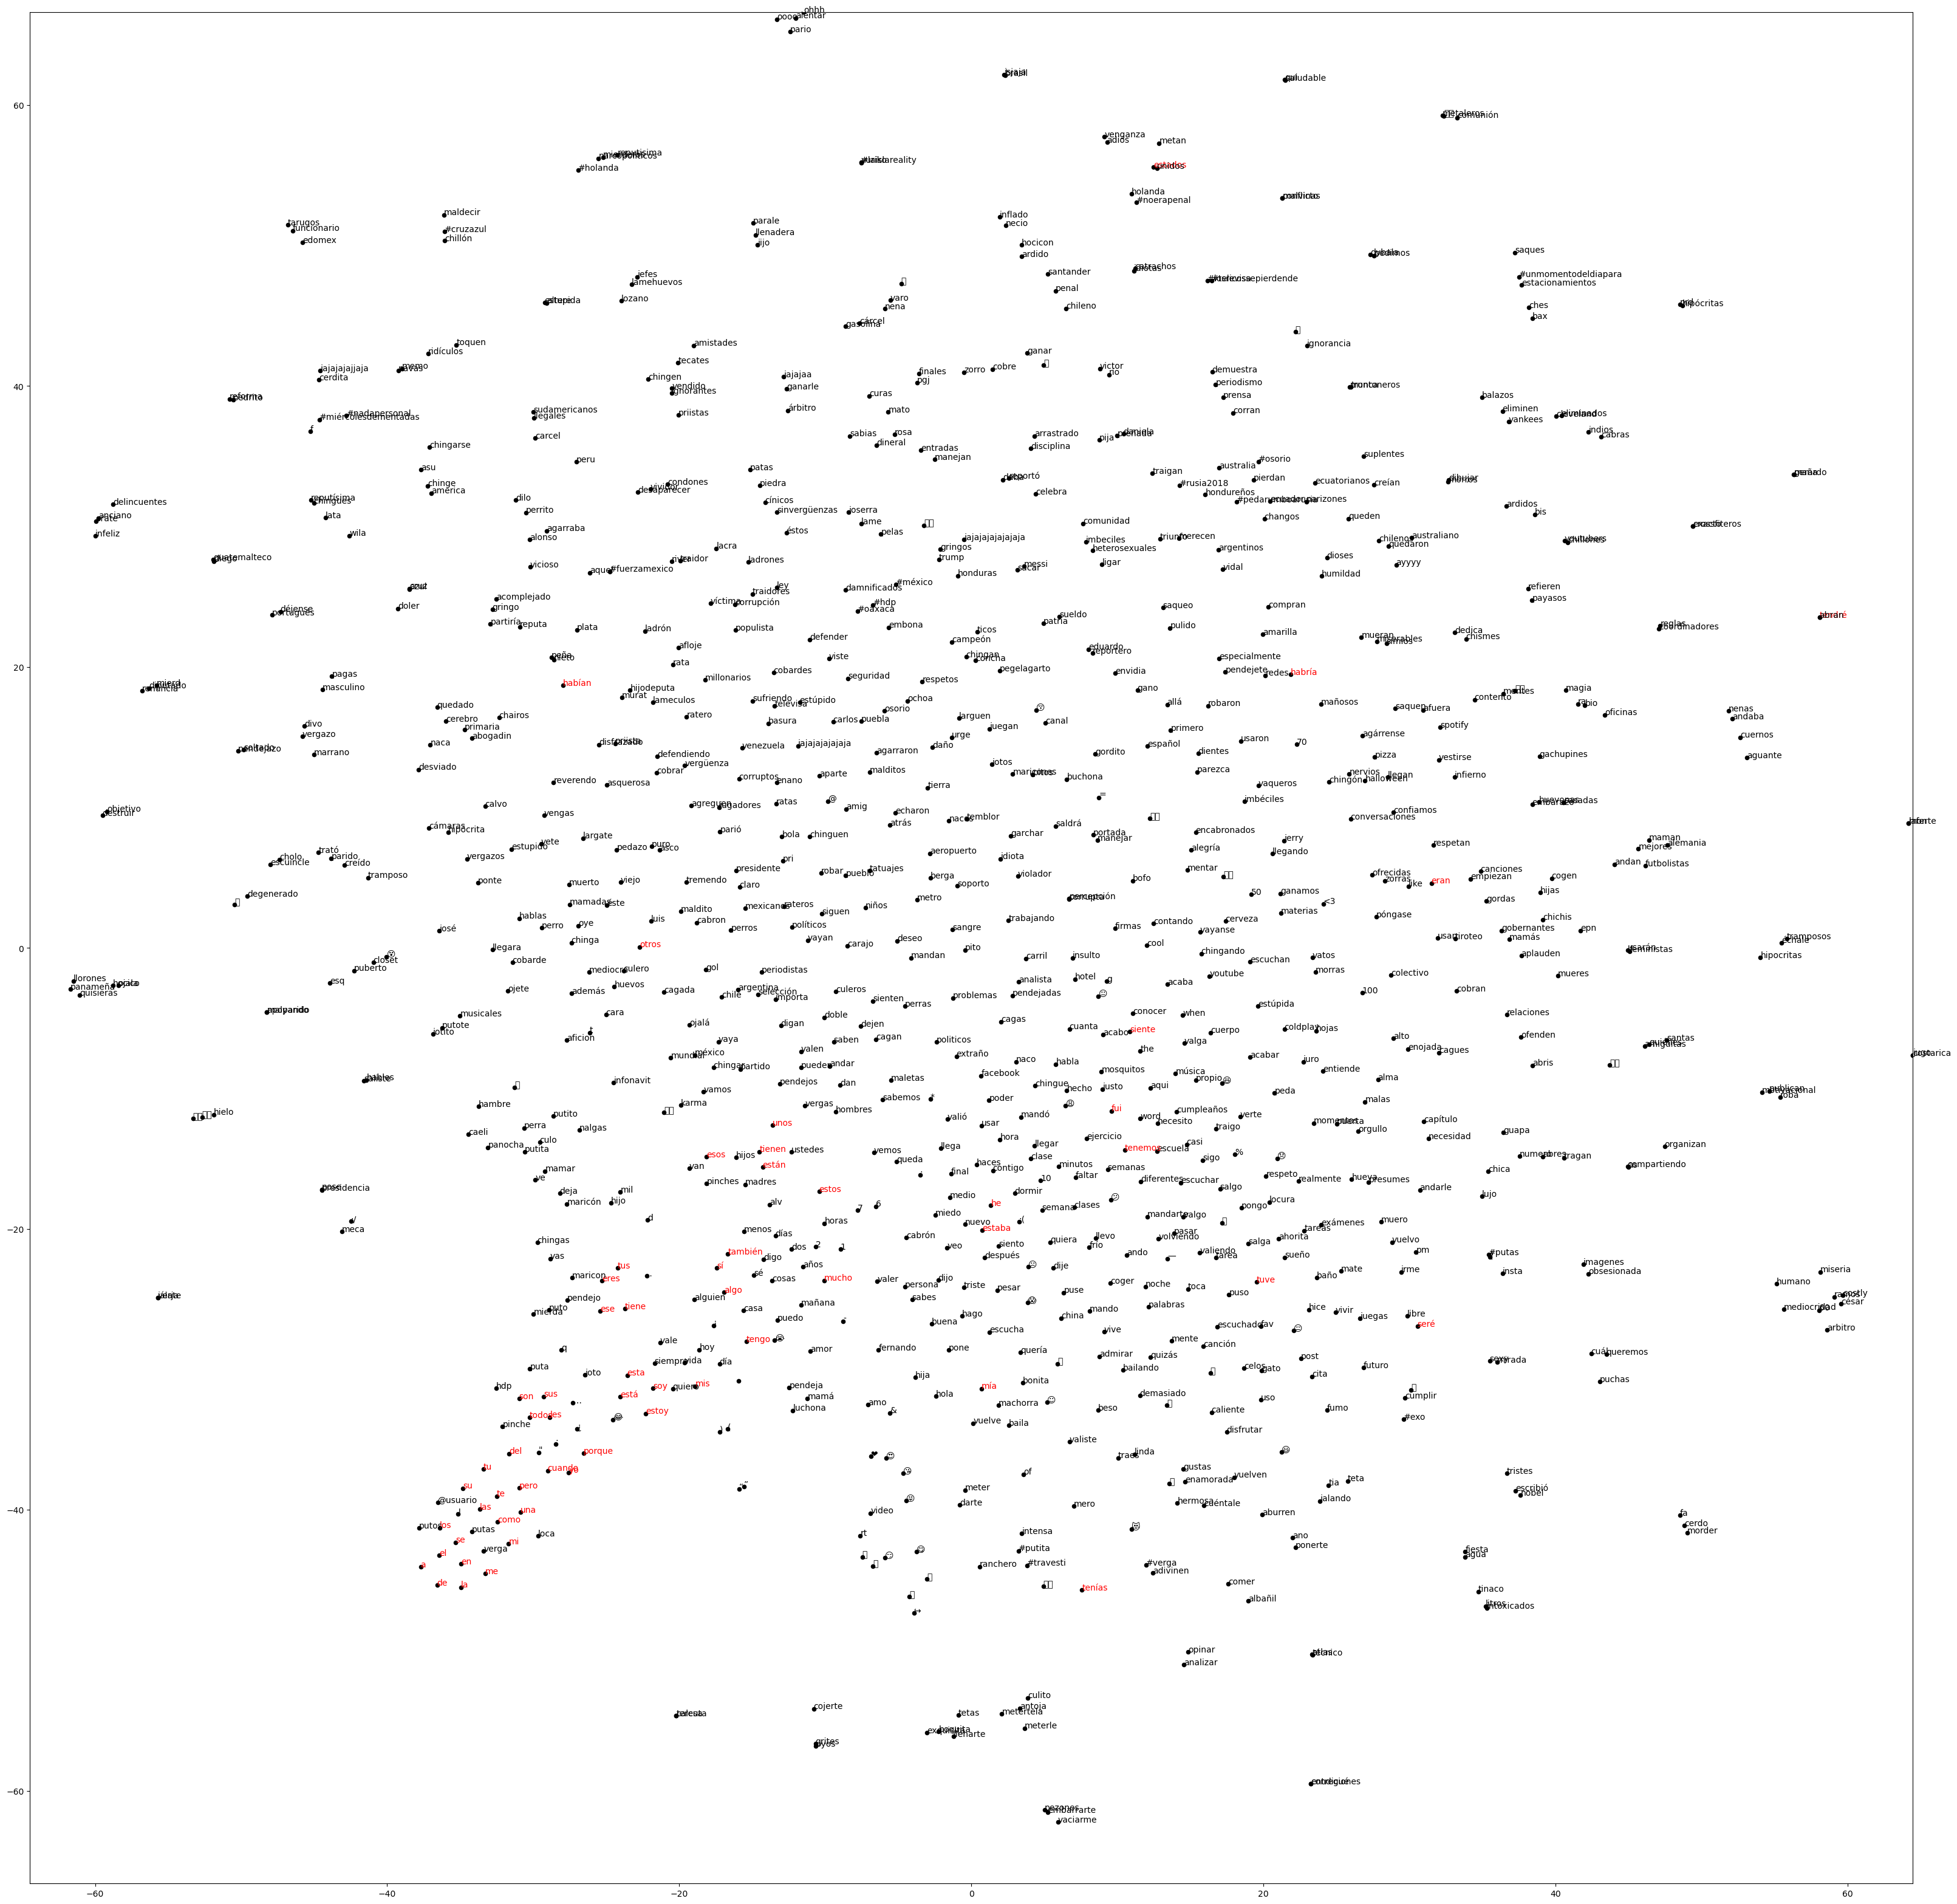

In [29]:
## Mapa de constelación de palabras

from nltk.corpus  import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

def constelation_plot(reduced_matrix, t_words):
    # reduced_matrix es la matriz de dimensión 2 obtenida por tsne
    # t_words son las palabras a graficar 
    
    # Limites de la gŕafica
    max_x = np.amax(reduced_matrix, axis=0)[0]
    max_y = np.amax(reduced_matrix, axis=0)[1]
    # Stopwords
    sw = set(stopwords.words("spanish"))
    plt.figure(figsize=(40,40), dpi = 100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y, max_y))
    plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color="black");
    # Graficación
    for idx, word in enumerate(t_words[:]):
        x = reduced_matrix[idx, 0]
        y = reduced_matrix[idx, 1]
        if word in sw:
            plt.annotate(word, (x,y), color = "red")
        else:
            plt.annotate(word, (x,y), color = "black")
            
constelation_plot(tcor_reduced, relevantw)

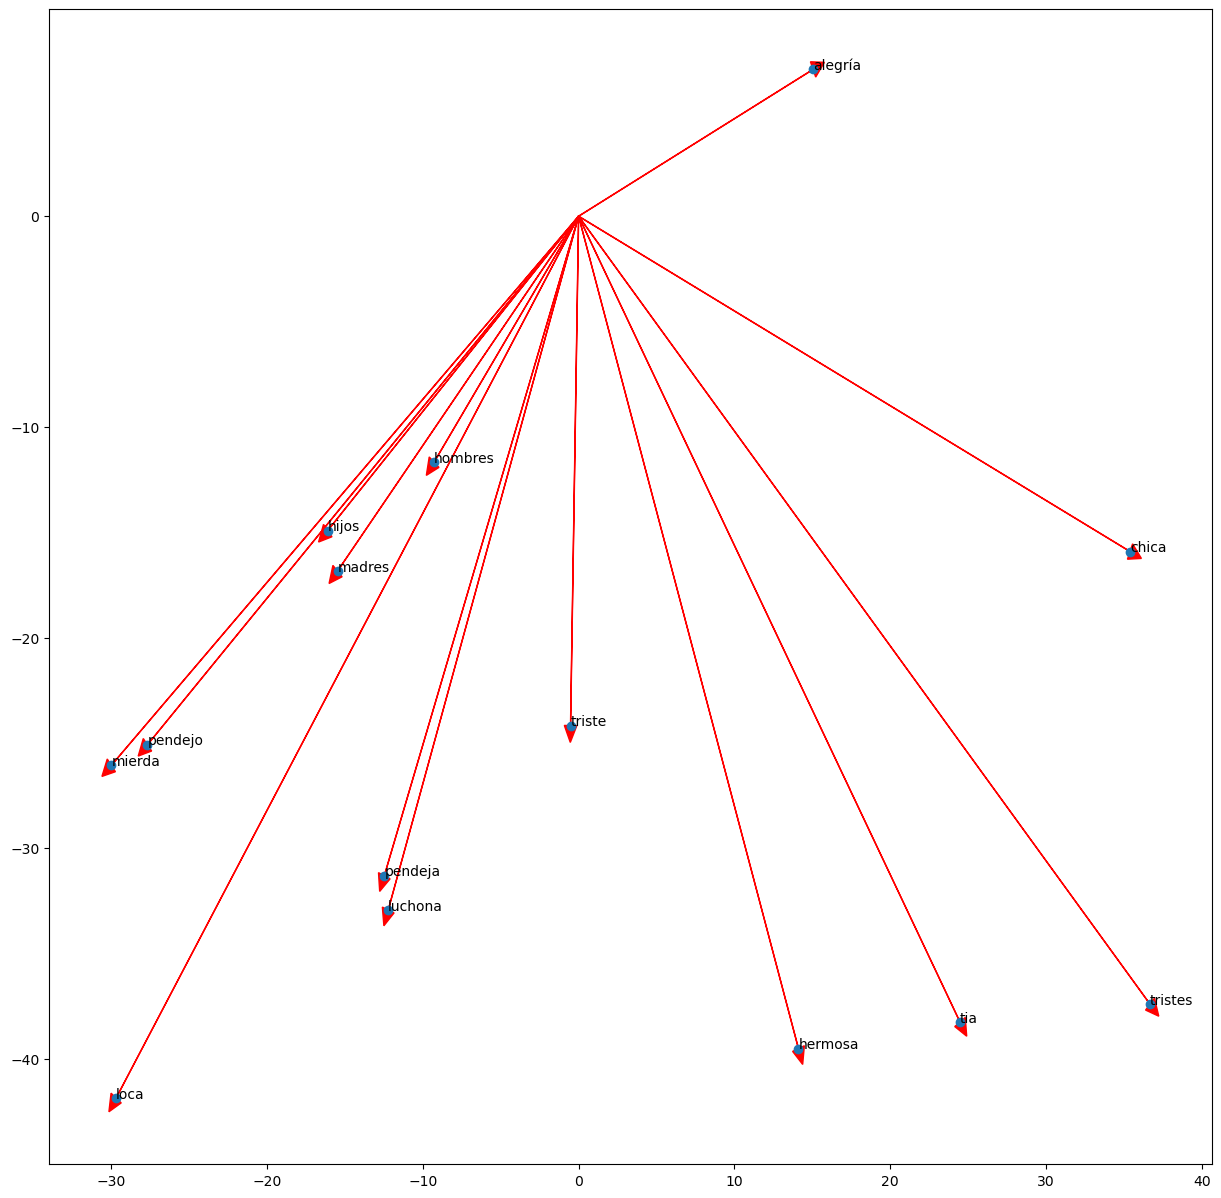

In [31]:
## Gráfica de subconjunto con centroide

subsetwords  = ["pendejo", "mexicano","tristes", "triste", "alegría","hermosa", "chica", "hombres", "madres", "hijos",
                "pendeja", "pendejo", "mierda", "loca", "tia" ,"luchona"]

def cloud_plot(reduced_matrix, t_words, subsetwords):
    subreduced_matrix = []
    ploted_subsetwords = []

    for idx, word in enumerate(t_words[:]):
        if word in subsetwords:
            ploted_subsetwords += [word]
            subreduced_matrix += [reduced_matrix[idx]]

    subreduced_matrix = np.array(subreduced_matrix)
    
    fig, ax = plt.subplots(figsize = (15,15))

    col1 = 0
    col2 = 1
    for word in subreduced_matrix:
        ax.arrow(0,0, word[col1], word[col2], head_width=0.8, head_length=0.8, fc = "r", ec = "r", width = 1e-2)

    ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:,col2])

    for i in range(0, len(ploted_subsetwords)):
        ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i,col2]))

    plt.show() 
    
cloud_plot(tcor_reduced, relevantw, subsetwords)

# 2. Calcular random indexing 

In [32]:
def build_index_vectors(cc, d):
    # cc es la matriz de coocurrencia palabra-contexto
    # d es la dimensión que tendrán los vectores indice
    
    # Muestreo
    i_vectors = np.random.normal(loc = 0, scale = 1, size = (cc.shape[1], d))
    for i in range(cc.shape[1]):
        for j in range(d):
            if i_vectors[i,j] < -0.5:
                i_vectors[i,j] = -1
            elif -0.5<=i_vectors[i,j]<=0.5:
                i_vectors[i,j] = 0
            else:
                i_vectors[i,j] = 1
    return i_vectors

def build_context_vectors(cc, i_vectors):
    # cc matriz de co-ocurrencia
    # i_vectors vectores indice
    
    context_v = np.zeros( (cc.shape[0], i_vectors.shape[1]), dtype = float)
    for iw in range(cc.shape[0]):
        context = np.nonzero(cc[iw])[0]
        for c in context:
            if(iw != c):
                context_v[iw] += i_vectors[c]*cc[iw, c]
    return context_v

In [33]:
# Se construyen los context vectors usando Random Indexing
index_vectors = build_index_vectors(cc_tr, 2000) # vectores indices         
random_indexing = build_context_vectors(cc_tr, index_vectors) # context vectors

# Se normaliza
from sklearn import preprocessing
random_indexing = preprocessing.normalize(random_indexing, norm ="l2")

In [34]:
# Se toman los 1000 vectores contextos mas relevantes de random indexing
ri_relevantw  = np.array([random_indexing[dict_indices[word]] for word in relevantw])

# Se realiza reducción de dimensionalidad con tsne
from tsne import tsne
ri_reduced = tsne(ri_relevantw, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.183169
Iteration 10: error is 17.826178
Iteration 20: error is 17.423683
Iteration 30: error is 17.269217
Iteration 40: error is 17.287145
Iteration 50: error is 17.272375
Iteration 60: error is 17.276501
Iteration 70: error is 17.276507
Iteration 80: error is 17.263679
Iteration 90: error is 17.275428
Iteration 100: error is 17.272309
Iteration 110: error is 2.202821
Iteration 120: error is 1.858067
Iteration 130: error is 1.741292
Iteration 140: error is 1.675235
Iteration 150: error is 1.630457
Iteration 160: error is 1.597741
Iteration 170: error is 1.574284
Iteration 180: error is 1.555832
Iteration 190: error is 1.540877
Iteration 200: error is 1.528794
Iteration 210: error is 1.518741
Iteration 220: error is 1.510347
Iteration 230: error is 1.503236
Iteration 240: error is 1.497224
Iteration 250: error is

/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ernesto/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  fig.canvas.pr

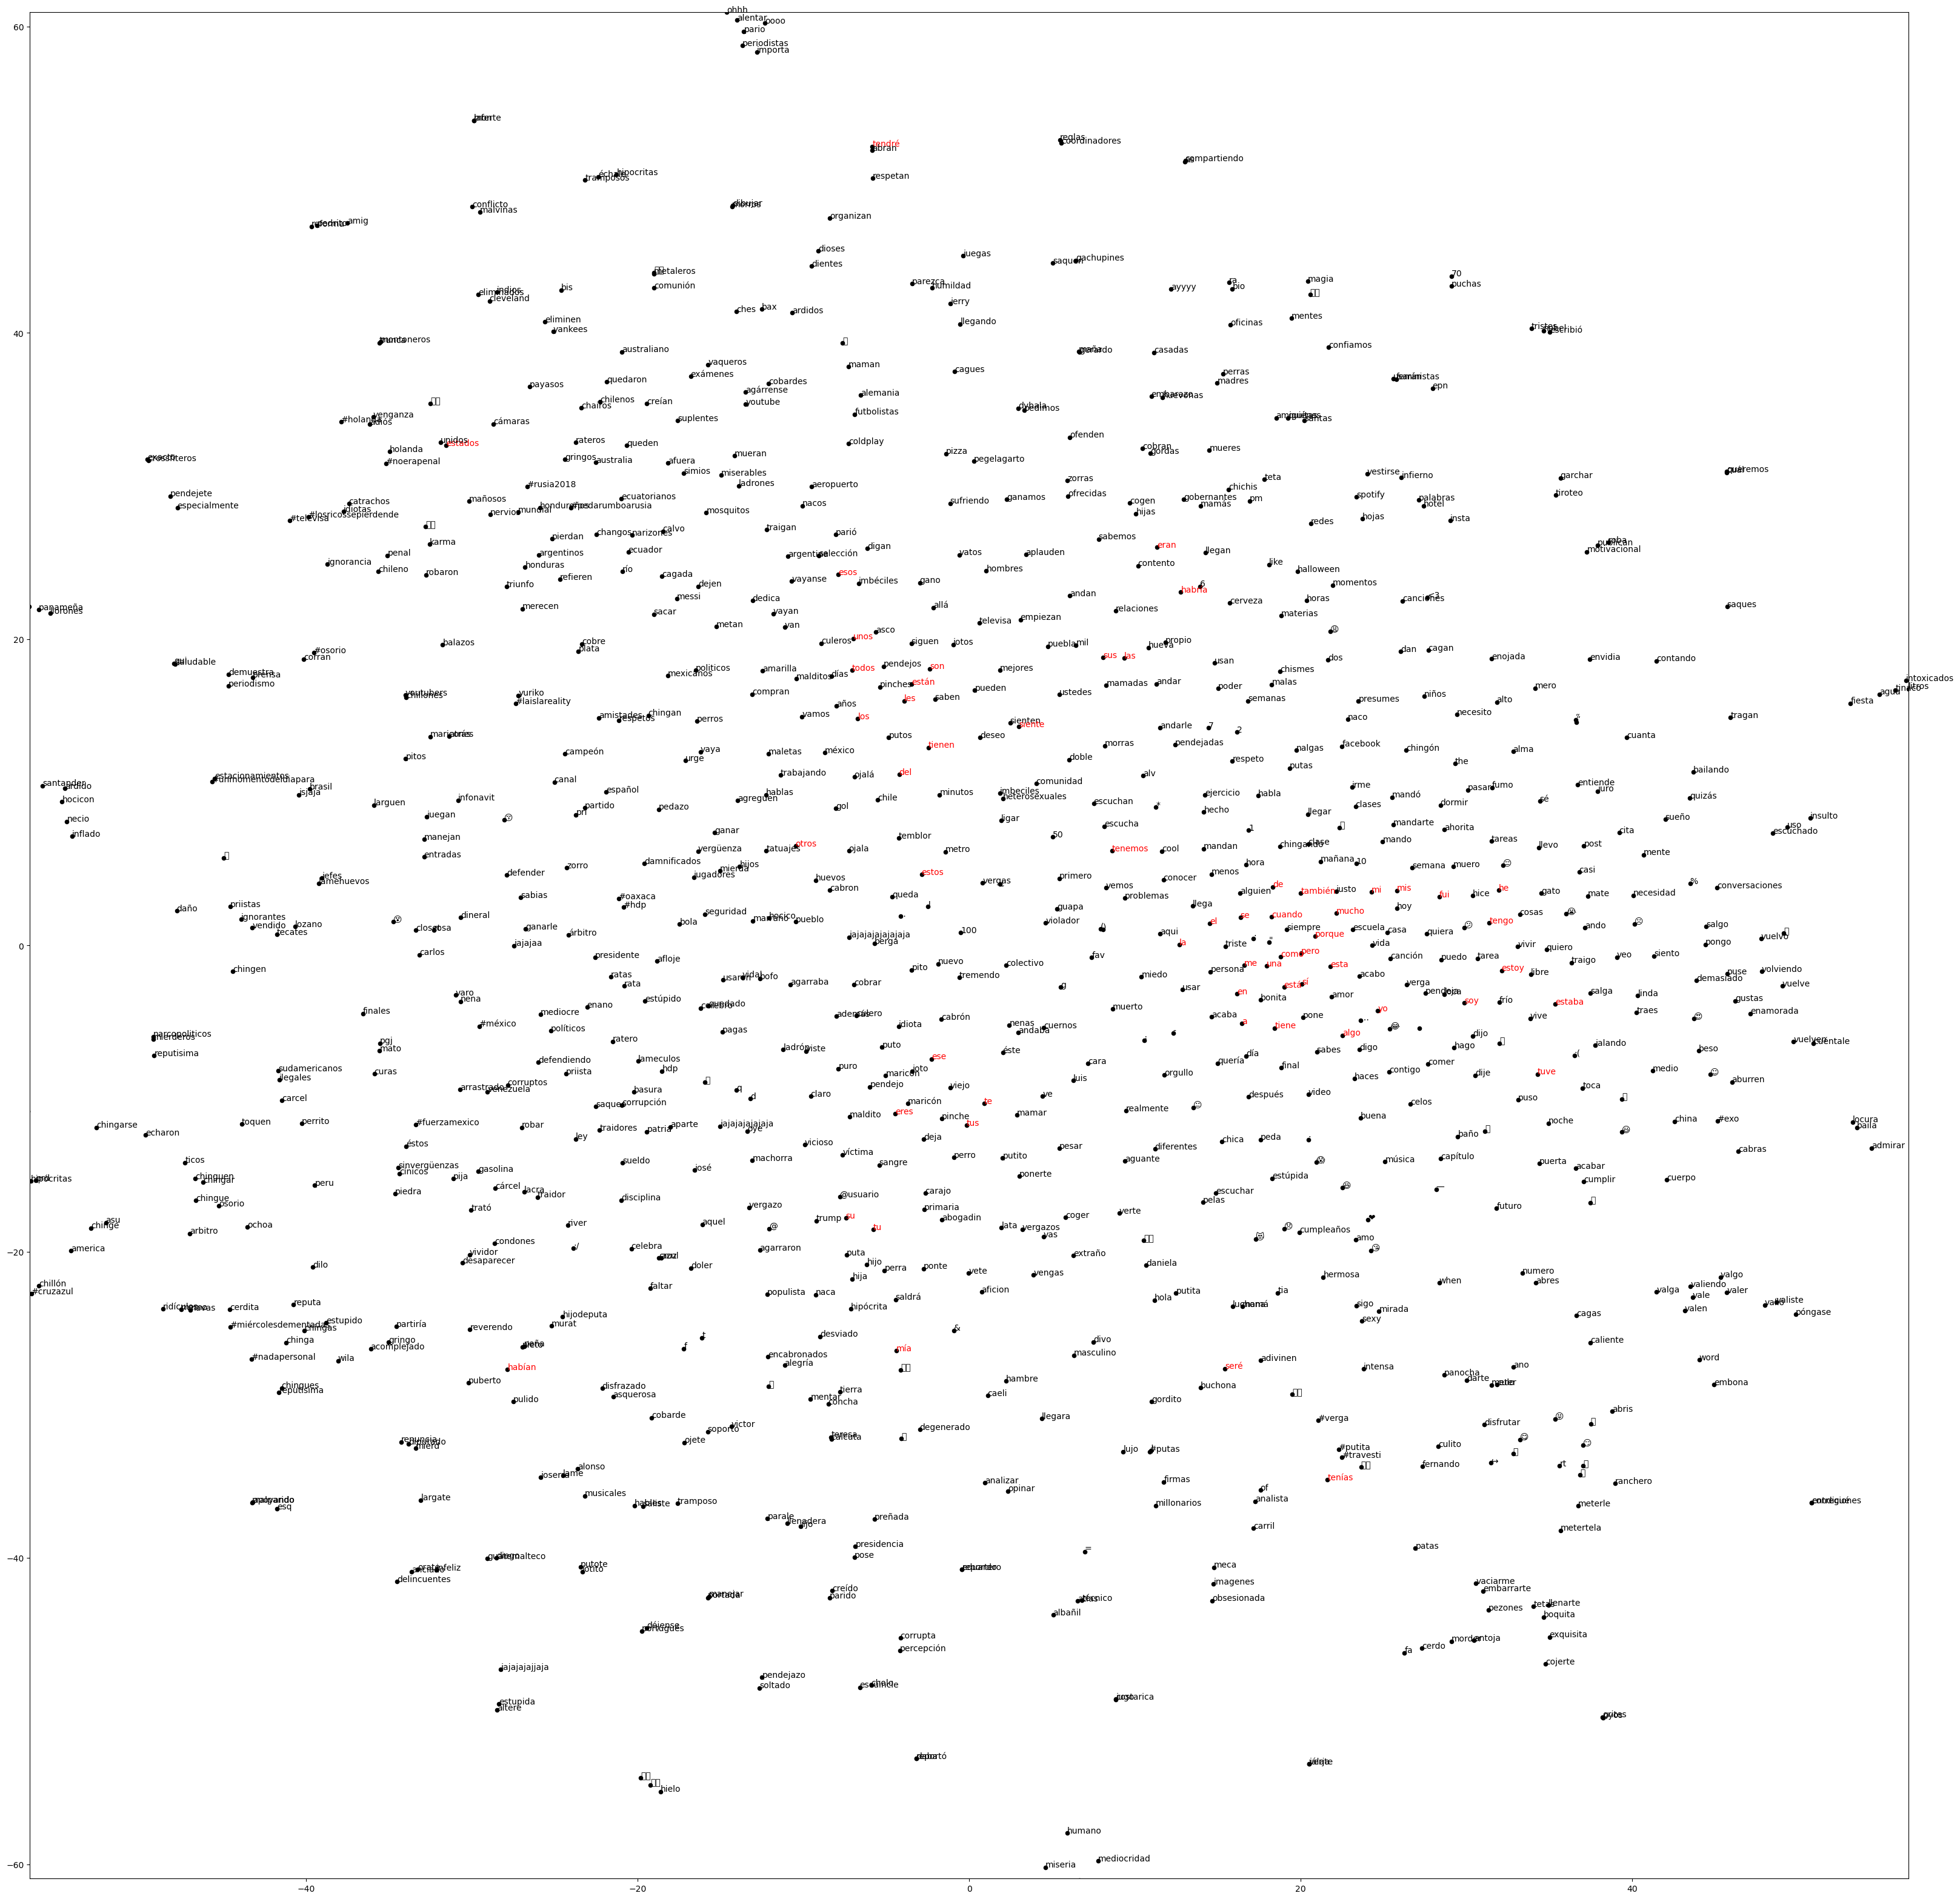

In [35]:
# Mapa de constelación de palabras
%matplotlib inline
constelation_plot(ri_reduced, relevantw)

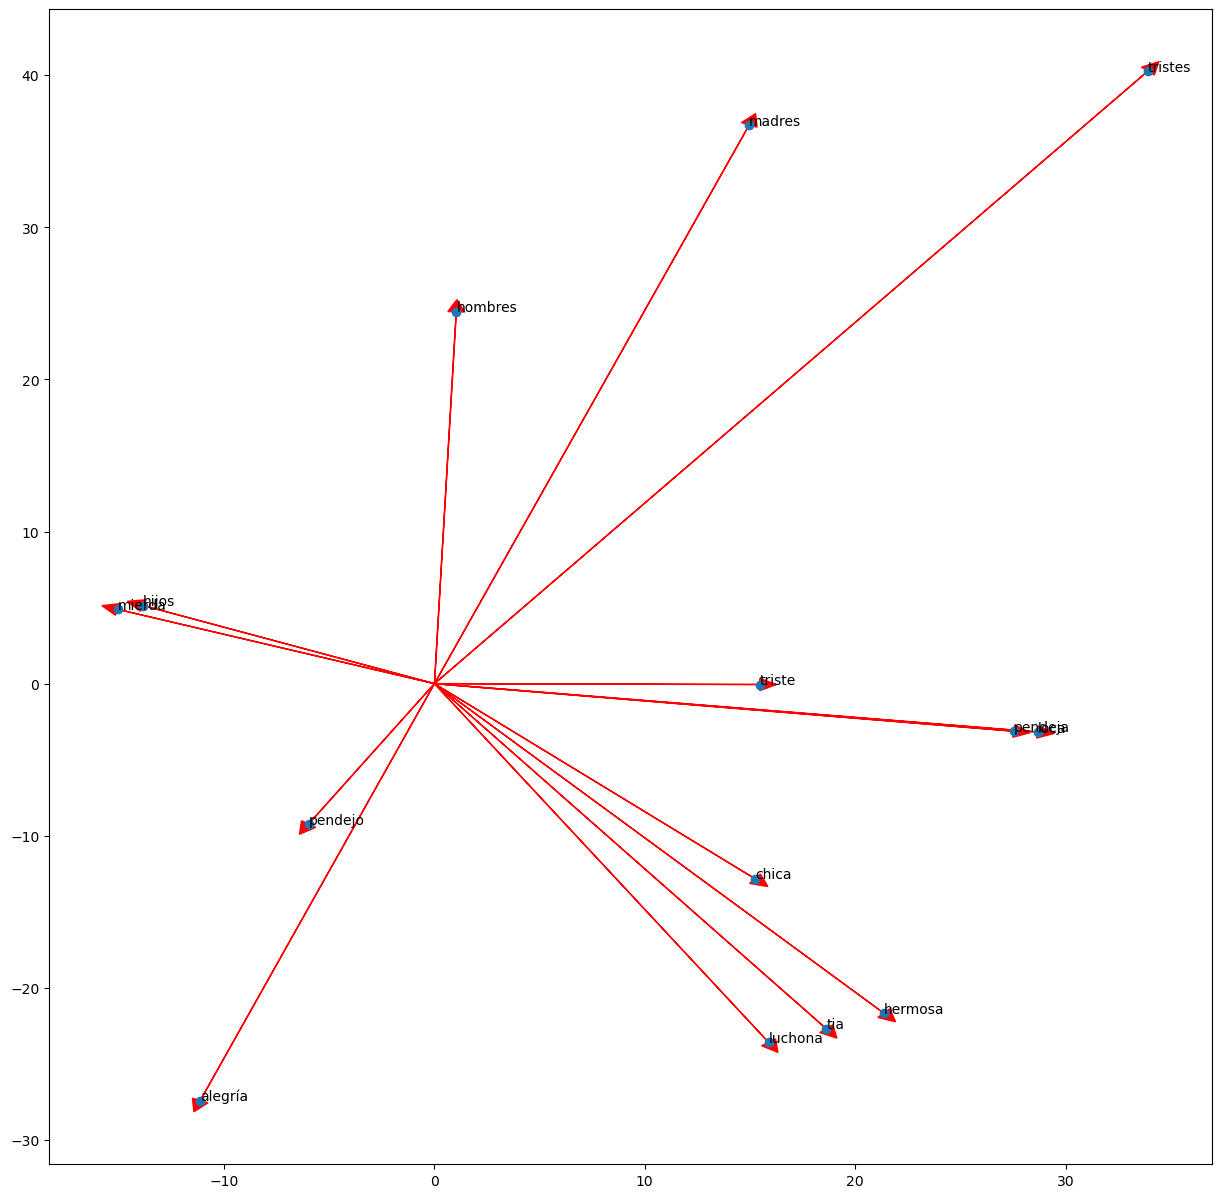

In [36]:
## Gráfica de subconjunto con centroide
# Se utilizarán las mismas palabras que el punto 1
cloud_plot(ri_reduced, relevantw, subsetwords)

# 3. Clasificación de documentos mediante DTRs

In [45]:
#Primero vamos a cargar los datos de validación 

# Se importan los datos de validación
val_text, val_y = get_texts_from_file("./mex_val.txt","./mex_val_labels.txt")
val_y = list(map(int, val_y)) # Para convertir las etiquetas a valores enteros (0 o 1)

In [43]:
# Bolsa de palabras binaria
def build_binary_bow(docs, V, dict_indices):
    BOW = np.zeros((len(docs), len(V)), dtype = int)
    cont_doc = 0
    for tr in docs:
        # Se crea el diccionario de frecuencias de este documento
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = 1
            
        cont_doc += 1
    return BOW

# Termino df para construir BoW tf-idf
def build_df(binary_bow):
    d, v = binary_bow.shape
    df = np.zeros(v)
    for i in range(v):
        df[i] = sum(binary_bow[:,i]) # Notar que el termino df es la suma de la columna en la bolsa binaria
    return df

# BoW (tf-idf)
def build_tfidf_bow(docs, V, dict_indices, df):
    BOW = np.zeros((len(docs), len(V)), dtype = float)
    cont_doc = 0
    for tr in docs:
        # Se crea el diccionario de frecuencias de este documento
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                # Esquema de pesado tf-idf
                tf = fdist_doc[word]
                # Recordar que dict_indices devuelve el ranking de una palabra (columna de la palabra)
                idf = math.log10(len(docs)/df[dict_indices[word]])
                BOW[cont_doc, dict_indices[word]] = tf*idf
        cont_doc += 1
    return BOW

In [46]:
# BoW tfidf (entrenamiento)
bow_bin_tr = build_binary_bow(tr_text, V, dict_indices)
df = build_df(bow_bin_tr)
bow_tfidf_tr = build_tfidf_bow(tr_text, V, dict_indices, df)

# BoW tfidf (validación)
bow_bin_val = build_binary_bow(val_text, V, dict_indices)
df = build_df(bow_bin_val)
bow_tfidf_val = build_tfidf_bow(val_text, V, dict_indices, df)

In [49]:
# Construye la representacion vectorial de un documento teniendo una representación vectorial del vocabulario
# La representación del documento es el promedio de las palabras que contiene.
def build_doc_rep(bow, words):
    # bow, matriz (#docs x #vocabulario) una bolsa de palabras binaria
    # words, matriz (#words x C) es la representación vectorial que se le dió a cada palabra usando C contextos
    
    doc = np.zeros( (bow.shape[0], words.shape[1]), dtype = float)# contendra la representación vectorial del documento
    for i in range(bow.shape[0]):
        nonzero = np.nonzero(bow[i])[0] # indices de las palabras que contiene el i-esimo documento
        for iw in nonzero:
            doc[i] += words[iw]
        doc[i] = doc[i]/len(nonzero)
    return doc

In [52]:
def build_ppmi(cc, alpha = 1):
    # cc es la matriz de co-ocurrencias entre palabras
    ppmi = np.zeros((cc.shape[0],cc.shape[0]), dtype = float) 
    s = [ sum(i) for i in cc] # suma por filas
    s_alpha = [ sum(np.power(i, alpha)) for i in cc ] # suma por filas con valores elevados a la potencia alpha
    total_cc = sum(s)
    total_cc_alpha = sum(s_alpha)
    for w in range(cc.shape[0]):
        for c in range(cc.shape[0]):
            pwc = cc[w,c]/total_cc
            if (pwc == 0):
                ppmi[w,c] = 0
            else: 
                pw = s[w]/total_cc
                pc = s_alpha[c]/total_cc_alpha
                ppmi[w,c] = max(0, math.log2(pwc/(pw*pc)))      
    return ppmi
    
ppmi_tr = build_ppmi(cc_tr, 0.75)
ppmi_tr = preprocessing.normalize(ppmi_tr, norm ="l2") # ppmi normalizado

In [53]:
# Representación vectorial palabras de entrenamiento
w_ppmi_tr = ppmi_tr # ya esta normalizado

# Representación vectorial palabras de validación
cc_val = build_ccmatrix(bow_bin_tr) # matriz de coocurrencia
w_ppmi_val = build_ppmi(cc_val, 0.75)

## Se normaliza
w_ppmi_tr = preprocessing.normalize(w_ppmi_tr, norm ="l2")# entranamiento
w_ppmi_val = preprocessing.normalize(w_ppmi_val, norm ="l2")# validación

In [54]:
doc_ppmi_tr = build_doc_rep(bow_bin_tr, w_ppmi_tr)# entrenamiento
doc_ppmi_val = build_doc_rep(bow_bin_val, w_ppmi_val)# entrenamiento

In [69]:
#Cargamos las librerias necesarias para crear y entrenar un modelo de svm
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_recall_fscore_support, roc_auc_score

tr_y = list(map(int,tr_y))

parameters = {'C':[.05,.12,.25,.5,1,2,4]}

#creamos nuestro modelo
svr = svm.LinearSVC(class_weight="balanced")
grid = GridSearchCV(estimator=svr,param_grid = parameters, n_jobs=4,scoring="f1_macro", cv=5)

In [71]:
# SVM
grid.fit(bow_tfidf_tr, tr_y)# Se ajusta el modelo al conjunto de entrenamiento
y_pred = grid.predict(bow_tfidf_val)# Se realiza la predicción del modelo con en conjunto de validación

/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ernesto/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarni

In [74]:
# Resultados
r_bow = metrics.classification_report(val_y, y_pred, output_dict = True)
print(metrics.classification_report(val_y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       397
           1       0.68      0.69      0.69       219

    accuracy                           0.78       616
   macro avg       0.76      0.76      0.76       616
weighted avg       0.78      0.78      0.78       616



In [75]:
#TCOR con PPMI

grid.fit(doc_ppmi_tr, tr_y)# Se ajusta el modelo al conjunto de entrenamiento
y_pred = grid.predict(doc_ppmi_val)# Se realiza la predicción del modelo con en conjunto de validación

In [76]:
r_ppmi = metrics.classification_report(val_y, y_pred, output_dict = True)
print(metrics.classification_report(val_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       397
           1       0.67      0.74      0.70       219

    accuracy                           0.78       616
   macro avg       0.76      0.77      0.76       616
weighted avg       0.78      0.78      0.78       616



In [77]:
#Comparamos los resultados

from tabulate import tabulate
table = [
    ["BoW tfidf", r_bow["0"]["f1-score"], r_bow["1"]["f1-score"],  r_bow["accuracy"]],
    ["TCOR-PPMI", r_ppmi["0"]["f1-score"], r_ppmi["1"]["f1-score"],  r_ppmi["accuracy"]]
       ] 
print (tabulate(table, headers=["Método", "F1 clase 0", "F1 clase 1", "Accuracy"]))

Método       F1 clase 0    F1 clase 1    Accuracy
---------  ------------  ------------  ----------
BoW tfidf      0.826802      0.689342    0.777597
TCOR-PPMI      0.822768      0.701525    0.777597


Si bien TCOR-PPMI muestra mejores resultados en general, esto solo es por muy muy poco, no es una gran ventaja la que se obtiene. Este resultado concuerda con los discutido en clase sobre que es muy dificil mejorar los resultados obtenidos por la bolsa de palabras.

# 4. Bajo TCOR mostrar los pares de palabras más parecidos

In [78]:
# Funcion que dado un conjunto de vectores encuentra los n más cercanos por medida del coseno
def find_best(target, n):
    # Target es el conjunto de vectores (normalizados)
    # n es la cantidad de mejores parejas a encontrar
    
    dim = target.shape[0]
    best = [] #guardará los 10 mejores
    minbest = 0 #el minimo del conjunto de los 10 mejores al momento
    for i in range(dim):
        for j in range(0,i):
            dist = target[i] @ target[j].T
            if dist >= minbest: # Si se encontro un valor que entra en el top 10 actual
                best.append((dist, (i,j))) # Se ingresa el nuevo
                best.sort() # Se ordena de menor a mayor
                if len(best) > n:
                    best.pop(0) # Se elimina el valor más bajo
                    minbest = best[0][0] # Se actualiza el minimo del top 10
    return best     

# Top 10 palabras cercanas
index_closestw = find_best(w_ppmi_tr, 10)
index_closestw.reverse()
closest_words = [ [dict_indice_invertido[w[1][0]], dict_indice_invertido[w[1][1]], w[0]] for w in index_closestw]

In [79]:
from tabulate import tabulate
print (tabulate(closest_words, headers=["Palabra 1", "Palabra 2", "Cercania"]))

Palabra 1    Palabra 2      Cercania
-----------  -----------  ----------
«            »              0.99923
daddy        sugar          0.999207
costly       césar          0.999154
costly       ramos          0.999154
césar        ramos          0.999154
cookies      leather        0.999087
autostop     lanzar         0.999069
axe          lanzar         0.999069
fragancia    lanzar         0.999069
autostop     axe            0.999069


# 5. BOW-TFIDF para los documetos mostrar los pares más parecidos

In [81]:
# Primero se normaliza la Bolsa TFIDF
from sklearn import preprocessing
bowL2 = preprocessing.normalize(bow_tfidf_tr, norm ="l2")

index_closestd = find_best(bowL2, 10)

index_closestd.reverse()
closest_docs = [ [tr_text[doc[1][0]], tr_text[doc[1][1]], doc[0]] for doc in index_closestd]

In [83]:
from tabulate import tabulate
print("Top 10 documentos más cercanos\n")
for doc, i in zip(index_closestd, range(len(index_closestd))):
    idoc1 = doc[1][0]; idoc2 = doc[1][1]
    print("------------")
    print("#", i+1, " con cercania:", doc[0])
    print("Categoría", tr_y[idoc1])
    print(tr_text[idoc1])
    print("Categoría", tr_y[idoc2])
    print(tr_text[idoc2])

Top 10 documentos más cercanos

------------
# 1  con cercania: 1.0
Categoría 0
una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer!  rt para más vídeos

Categoría 0
una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer! rt para más vídeos

------------
# 2  con cercania: 0.9955393732319239
Categoría 0
quiero un pasivo que se ensarte mi verga así 🔥🔥como @usuario cabalga la verga de  @usuario

Categoría 0
quiero un pasivo que se ensarte mi verga así 🔥🔥como @usuario cabalga la verga de  @veguerovzla

------------
# 3  con cercania: 0.9842531765386593
Categoría 0
me estaba valiendo verga el mundo hasta que llegaste tú.

Categoría 0
me estaba valiendo madre el mundo hasta que llegaste tú.

------------
# 4  con cercania: 0.9816174955756831
Categoría 0
hdp!y sale caminando y mantiene sus laburo cdo en todos los contratos dice q deben tener buena conducta..este encima dice q estaba en pedo😠

Categoría 1
@usuario @usuar

# 6. Implemente Ganancia de Información o Chi2 para descubrir el top 50 de las palabras más relevantes de TODA la colección. 

Vamos a implementar ganancia de información 

In [93]:
# Encuentra los mejores n de un arreglo y devuelve sus indices
def best_n(a, n):
    # a arreglo
    # n top a encontrar
    best = [] # guardará los mejores
    minbest = float("-inf") #minimo del conjunto del top n al momento
    for i in range(len(a)):
        if a[i] >= minbest: #si hay un valor que entra en el top
            best.append( (a[i], i) )
            best.sort()
            if len(best) > n:
                best.pop(0)
                minbest = best[0][0]
    return best

In [94]:
from collections import Counter

# Construye la tabla de incidencia termino-clase
def build_tc_table(docs, y, V, dict_indices):
    # docs son los documetntos a análizar
    # y son las etiquetas
    # V es el vocabulario
    # dict_indices es el diccionario (palabra -> ranking)
    
    c = Counter(y)# Se cuenta cantidad de documentos en cada clase
    # Valores generales
    nclase0 = c[0] # Docs en clase 0
    nclase1 = c[1] # Docs en clase 1
    Nt = nclase0 + nclase1 # Docs totales
    
    # Tabla de incidencia
    incidencia = np.zeros( (len(V),2,2), dtype = int)
    
    idoc = 0 # indice de documento analizando
    for doc in docs:
        # Se crea el diccionario de frecuencias de este documento
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(doc))
        
        for word in fdist_doc:
            if word in dict_indices:
                iword = dict_indices[word] # indice del término
                # Se suma 1 documento que contine el termino word
                # Se suma en su respectiva clase y[idoc]
                incidencia[iword, 0, y[idoc]] += 1     
        idoc += 1
        
    for tablaw in incidencia:
        tablaw[1, 0] = nclase0 - tablaw[0, 0]
        tablaw[1, 1] = nclase1 - tablaw[0, 1]
        
    return nclase0, nclase1, Nt, incidencia

nclase0, nclase1, Nt, tc = build_tc_table(tr_text, tr_y, V, dict_indices)
#tc es la tabla de incidencia termino-clase
#nclasei  es la cantidad de docs en la clase i
#Nt es la cantidad total de docs

In [95]:
def log(x):
    if(x == 0):
        return float("-inf")
    else:
        return math.log10(x)

# auxiliar para calcular Ganancia de información
def IG_util(iword, np, Nt, tc, c):
    #iword indice de la palabra
    #np num docs en clase p
    #Nt total docs
    #tc tabla incidencia
    #c es la clase 0 o 1
    
    #auxiliares
    nip = tc[iword, 0, c]
    ni = tc[iword, 0, 0]+tc[iword, 0, 1]
    a = (np/Nt)*log(np/Nt)
    if(nip == 0):
        b = float('-inf')
    else:
        b = (nip/Nt)*log(nip/ni)
    c = (np-nip)/Nt*log((np-nip)/(Nt-ni)) 
    return a-b-c
    
# Calculo de ganancia de información
nclase0, nclase1, Nt, tc = build_tc_table(tr_text, tr_y, V, dict_indices)
IG = np.zeros(len(V), dtype = float) 
for iword in range(len(V)):
    #IG clases
    c0 = IG_util(iword, nclase0, Nt, tc, 0)
    c1 = IG_util(iword, nclase1, Nt, tc, 1)
    IG[iword] = -(c0+c1)

In [96]:
top50IG = best_n(IG, 50) # Lista de parejas (IG, index_w) ascendentemente por IG
top50IG.reverse()
top50IG = [ (dict_indice_invertido[w[1]], w[0]) for w in top50IG ] 
top50IG

[('loca', 0.01599641917686012),
 ('hdp', 0.013474740829014398),
 ('@usuario', 0.010210833281559556),
 ('putos', 0.006562910568788383),
 ('me', 0.004939069773146662),
 ('tu', 0.00390810471743383),
 ('hijos', 0.0033355970600142393),
 ('pendejo', 0.003295972663711108),
 ('estoy', 0.0031339546989897077),
 ('puto', 0.003101845419567012),
 ('son', 0.0030806111634409383),
 ('mamar', 0.002925299783872834),
 ('puta', 0.0029040921927075414),
 ('chinguen', 0.002831314719631342),
 ('pendejos', 0.0027809601771100756),
 ('mierda', 0.0027009000238624875),
 ('hijo', 0.0026152551765620258),
 ('mi', 0.0024643184338290075),
 ('verga', 0.0024411851805131585),
 ('pinche', 0.0023177820403970095),
 ('los', 0.0021921774888525453),
 ('chinga', 0.001843902846344725),
 ('chingas', 0.0018275265854459793),
 ('pinches', 0.001765254566059915),
 ('su', 0.0017353778875409537),
 ('esos', 0.0016681556075208853),
 ('mundial', 0.0016404398954454474),
 ('vida', 0.0016348199435531618),
 ('a', 0.0016292154823136645),
 ('chin

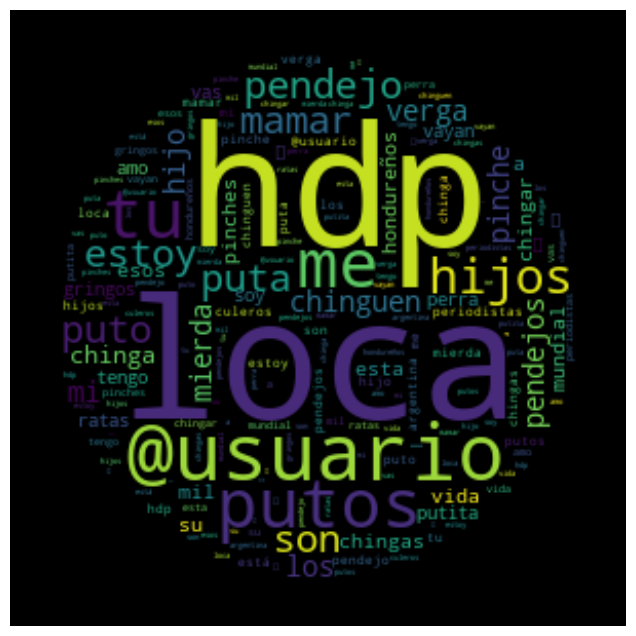

In [103]:
import multidict as multidict
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
    
    
def plotCloud(txt):
    text = multidict.MultiDict(txt)
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    wc = WordCloud(background_color="black", repeat = True, mask = mask )
    wc.generate_from_frequencies(text)

    plt.figure(figsize=(8,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
plotCloud(top50IG)